In [1]:
import tomotopy as tp
import pandas as pd
import pickle
import numpy as np
import sys
import nltk
from nltk import word_tokenize, RegexpTokenizer,PunktSentenceTokenizer, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import re

# Topics embeddings pipeline 
Here we implement the embedding pipeline for the topics extracted by the collection. <br>
The results will be the following: 
1. Topic embeddings 
2. Document embeddings 
3. Other nodes embeddings? 

## 1. Loading topic model(s) and collection

In [2]:
collection = pickle.load(open( "collection_cleaned_fullwords.p", "rb" ))

In [3]:
num_batches = 4
batches = np.array_split(collection, num_batches)

In [61]:
def get_batch_indices(batches):
    res = []
    for i,batch in enumerate(batches):
        res += [i]*len(batch)
    return res
batch_indices = get_batch_indices(batches)

In [4]:
# number of docs per batch
for b in batches: print(len(b))

5124
5124
5123
5123


Batch training models 

In [192]:
num_topics_per_batch = 125
models = []
model_names = ['LDA1batch1.bin','LDA1batch2.bin','LDA1batch3.bin','LDA1batch4.bin']
for name in model_names:
    models.append(tp.LDAModel.load(name))

## 2. Extract the topics 

In [193]:
def get_top_topics(document, model, min_score=0.8):
    """ 
    Extracting top n topics for each document. 
    Selects the n most likely topics whose p(topic|document) sum to min_score.
    """
    # inserting the document in the model
    new_doc = model.make_doc(document)
    _,_ = model.infer(new_doc)
    # ordering from most probable topic to least one 
    dist = new_doc.get_topic_dist()
    indices = np.flip(np.argsort(dist))
    score = 0
    indices_kept = []
    probs_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        indices_kept.append(index)
        probs_kept.append(dist[index])
    return list(zip(indices_kept, probs_kept))

In [194]:
# extracting topics for the original collection
coll2topics = []
# this takes a super long time
for model, batch in zip(models,batches):
    coll2topics += [get_top_topics(doc, model) for doc in batch]

In [195]:
len(coll2topics)

20494

In [196]:
def get_top_words(topic, model, min_score=0.8):
    """
    Extracting top n words for each document. 
    Selects the n most likely words whose p(word|topic) sum to min_score.
    """
    dist = model.get_topic_word_dist(topic)
    indices = np.flip(np.argsort(dist))
    score = 0
    word_kept = []
    word_prob_kept = []
    for index in indices:
        if score > min_score: break
        score += dist[index]
        word_kept.append(model.used_vocabs[index])
        word_prob_kept.append(dist[index])
    return list(zip(word_kept, word_prob_kept))

In [197]:
topics2words = []
topics2words_batched = [] # saving both topics and their batches 
for model in models: 
    # extracting only top 25% of the words
    twt = [get_top_words(i, model, min_score=0.25) for i in range(num_topics_per_batch)]
    topics2words += twt
    topics2words_batched += [twt]

In [198]:
len(topics2words)

500

In [199]:
len(topics2words_batched)

4

## 3. Embedding words in topics

We will use Glove Embeddings to embed the words in the topics. 

In [200]:
import pickle 
import numpy as np 
import os 
import time
import torch

In [201]:
# Loading from binary the glove vocabulary and embedding 
glove_vocab_path = "glove_vocab"
glove_embedding_path = "glove_embedding"
with open(glove_vocab_path, "rb") as fp:  
    glove_vocab = pickle.load(fp)
with open(glove_embedding_path, "rb") as fp: 
    glove_embedding = pickle.load(fp)

In [202]:
def get_list_embeddings_topic(topic, vocab, embedding, silence=False):
    """ Topic is represented as a list of tuples (word, word weight)"""
    matched = 0 
    total = 0
    topic_embeddings = []
    topic_weights = []
    
    start = time.time()
    
    for item in topic: 
        word, weight = item
        total+=1
        #check if the word appears in vocabulary 
        if word in vocab.values(): 
            matched+=1
            emb = embedding[list(vocab.values()).index(word)]
            topic_embeddings += [emb.numpy()]
            topic_weights += [weight]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
        print("Proportion of matched words: "+str(round(matched/total,2)))
    return topic_embeddings, topic_weights

In [203]:
topic_embeddings, topic_weights = get_list_embeddings_topic(topics2words[0], glove_vocab, glove_embedding)

Total time: 0.25 s.
Proportion of matched words: 0.96


# Embedding nodes - baseline

## 4. Embedding topics 

In [204]:
def get_convex_combination(weights, embeddings):
    """ Obtain an embedding as convex combination of embedding vectors according 
    to the weights provided."""
    weight_vec = np.asarray(weights)
    emb_vec = np.asarray(embeddings)
    normalized_weights = weight_vec / np.sqrt(np.sum(weight_vec**2))
    return normalized_weights.transpose().dot(emb_vec)

In [205]:
topic_emb = get_convex_combination(topic_weights, topic_embeddings)

In [209]:
def get_convex_topics_embeddings(topics_collection, vocab, embedding):
    """ Runs the above function over a whole collection of topics"""
    topics_embs = []
    for topic2word in topics_collection:
        # extract the emebddings for the words in the topic 
        topic_embeddings, topic_weights = get_list_embeddings_topic(topic2word, vocab, embedding, silence=True)
        # combine the embeddings with a convex sum 
        topic_emb = get_convex_combination(topic_weights, topic_embeddings)
        topics_embs += [topic_emb]
    return topics_embs

In [207]:
# TODO: look at topic embeddings across batches and measure their similarity

In [210]:
topics_embs = get_convex_topics_embeddings(topics2words, glove_vocab, glove_embedding)

In [211]:
topics_embs_batched = [get_convex_topics_embeddings(t2w, glove_vocab, glove_embedding) for t2w in topics2words_batched]

Now let's have a look at the results!

In [212]:
def nearest_neighbors(this, others):
    """Returns the most similar vectors among others to the given one """
    cos = torch.nn.CosineSimilarity(dim = -1)
    ranks = cos(torch.tensor(this), torch.tensor(others))
    mostSimilar = []
    return ranks.numpy().argsort()[::-1] 

In [24]:
# let's look at the first topic 
nns_100 = nearest_neighbors(topics_embs[100], topics_embs)

In [213]:
def visualise_most_similar_topics(topic_id, batch_id, topics_embs, topics2words,
                                  topics_embs_batched, topics2words_batched, n=10):
    """Prints the words of the topic and its neareast neighbors."""
    nns = nearest_neighbors(topics_embs_batched[batch_id][topic_id], topics_embs)
    print("-"*10)
    print("Topic "+ str(topic_id))
    print(" ".join(item[0] for item in topics2words_batched[batch_id][topic_id]))
    print("-"*10)
    print(str(n)+" most similar topics")
    for i in range(n):
        print("Topic "+str(nns[i+1]))
        print(" ".join(item[0] for item in topics2words[nns[i+1]]))

In [214]:
visualise_most_similar_topics(35, 1, topics_embs, topics2words,topics_embs_batched, topics2words_batched, n=3)

----------
Topic 35
pm soils quartz fr pretreatment soil floodplain pre grid graphite confinement steam lean environment
----------
3 most similar topics
Topic 426
soil crisis plants soils restoration biomass communities growth
Topic 89
soil drought plant biomass organic microbial fluxes ecosystem nutrient
Topic 277
sediment sediments water sedimentary deep depth basin hypoxia incision mixing catchment


## 5. Documents embeddings

In [215]:
abstracts_data = pd.read_csv("abstracts_eng.csv")

In [216]:
# checking the ordering by visual inspection 
n = np.random.randint(len(collection))
print(abstracts_data["abstract"][n][0:500]) 
print("")
print(" ".join(collection[n][0:50]))

Uncertainty shapes the trajectory of business cycles and remains a central research topic in Macroeconomics. When studying the impact of uncertainty on the economy, economists use different uncertainty measures. While all indicators approximate uncertainty along some certain dimension, none of the indicators directly captures Knightian Uncertainty. According to Knight, uncertainty represents a situation in which it is no longer possible to form expectations about the future. In this study, we pr

uncertainty shapes trajectory business cycles remains central research topic macroeconomics studying impact uncertainty economy economists use different uncertainty measures indicators approximate uncertainty along certain dimension none indicators directly captures knightian uncertainty according knight uncertainty represents situation longer possible form expectations future study propose method directly measure knightian uncertainty approach relies


In [217]:
enriched = abstracts_data
enriched["topics"] = coll2topics
enriched["batchID"] = batch_indices
#enriched=enriched.explode("topics")
enriched.head(5)

,abstract,id,title,topics,batchID
0,The goal of this note is to introduce new clas...,188444.0,Asymptotic versions for operators and operator...,"[(60, 0.24186938), (51, 0.10589432), (79, 0.07...",0
1,We will review a Lemma published by Ran Raz in...,188623.0,Some remarks on a lemma of Ran Raz,"[(5, 0.20627172), (40, 0.16780958), (29, 0.108...",0
2,China’s growing influence in Europe has the po...,346708.0,China as a Stress Test for Europe’s Coherence,"[(0, 0.14767313), (14, 0.1092189), (25, 0.0920...",0
3,Nowhere is China's Belt and Road Initiative (B...,346709.0,"On the Belt, on the Road: China’s Pivot to Eur...","[(57, 0.16084893), (0, 0.14146255), (16, 0.098...",0
4,Passenger transit modes typical of the urban s...,187461.0,Applications and Future Developments: Modellin...,"[(14, 0.11849773), (16, 0.07719317), (2, 0.072...",0


In [218]:
docs2topics = enriched[["topics","batchID"]].values.tolist()

In [219]:
def get_list_embeddings_document(doc, topics_embedding, silence=False):
    """ Returns the list of topic embeddings and topic weights for the given document.
    The document is represented as the tuple ([(topic_id, topic_weight)], batch_id)"""
    doc_embeddings = []
    doc_weights = []
    
    start = time.time()
    
    topics, batch_id = doc
    
    for topic in topics: 
        topic_id, weight = topic
        emb = topics_embedding[batch_id][topic_id]
        doc_embeddings += [emb]
        doc_weights += [weight]
    
    end = time.time()
    if not silence: 
        print("Total time: "+str(round(end-start,2))+" s.")
    return doc_embeddings, doc_weights

In [220]:
doc0_embs = get_list_embeddings_document(docs2topics[0], topics_embs_batched)
len(doc0_embs[0])

Total time: 0.0 s.


10

In [221]:
# finally documents embeddings 
def get_convex_docs_embeddings(documents_collection, topics_embedding):
    """ Runs the above function over a whole collection of documents"""
    docs_embs = []
    for doc2topics in documents_collection:
        # extract the emebddings for the words in the topic 
        doc_embeddings, doc_weights = get_list_embeddings_document(doc2topics, topics_embedding, silence=True)
        # combine the embeddings with a convex sum 
        doc_emb = get_convex_combination(doc_embeddings, doc_weights)
        docs_embs += [doc_emb]
    return docs_embs

In [222]:
documents_embeddings = get_convex_docs_embeddings(docs2topics, topics_embs_batched)

In [223]:
def visualise_most_similar_docs(doc_id, docs_embeddings, docs_collection, n=10):
    """Prints the words of the topic and its neareast neighbors."""
    nns = nearest_neighbors(docs_embeddings[doc_id], docs_embeddings)
    print("Document "+ str(doc_id))
    print((docs_collection[doc_id]).partition("||")[0])
    print("-"*10)
    print(str(n)+" most similar documents in the collection")
    for i in range(n):
        print("")
        print("Document "+str(nns[i+1]))
        print((docs_collection[nns[i+1]]).partition("||")[0])

In [224]:
visualise_most_similar_docs(5, documents_embeddings, abstracts_data["abstract"], n=10)

Document 5
As the strategic rivalry between the US and China intensifies, militarized crises are becoming more likely and a major military conflict is no longer as remote as it once seemed. The far-reaching modernization of its armed forces has already led China to embrace a more sanguine view of how such a conflict might play out. Meanwhile, the United States is struggling to formulate a coherent response to a potential Chinese attempt to recast the regional order by force. Although war remains unlikely, the need to get real about the possibility is now more urgent than at any point in recent decades.
----------
10 most similar documents in the collection

Document 6
US-Chinese rivalry is becoming the prime mover of global affairs. Though the long-term trajectory of this critical relationship is uncertain, several salient factors are already apparent: pernicious variations of nationalism on both sides; foreign policies that are increasingly shaped by domestic problems; and a growing t

## 6. Authors embeddings

In [133]:
# loading the graph data 
graph_data = pd.read_csv("graph_data_final.csv")
# author2doc
# org2people

## 5. Embedding topics - representation learning 

In [27]:
# Idea: a simple autoencoder to reconstruct topics embeddings
# The autoencoder takes as input the topic 2 word distribution and finds 
# a representation of the topic able to reconstruct it (+ idea: add noise in the input)
# We will enforce similarity with the topic words by applying a regulariser that measures 
# the non-similarity with the topic words 

In [28]:
import torch 
from torch import nn

In [29]:
class topicsLoss(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def topic_words_dissimilarity(self, hidden, topicwords_embs, topicwords_weights):
        """ 
        topicwords_embs: torch tensor of size BATCH x NUM_WORDS x EMB_DIM 
        topicwords_weights: torch tensor of size BATCH x NUM_WORDS 
        
        """
        # 1. normalise the weights 
        normalized_weights = weight_vec / np.sqrt(np.sum(weight_vec**2))
        # 2. compute hidden - embeddings distances
        distances = torch.cdist(topicwords_embs,hidden) # B x W
        # 3. dot product of weights and distances 
        total loss = 
        return total_loss 
    
    def forward(self, outputs, targets, hidden, topicswords_embs, topicswords_weights):
        loss = self.mse(outputs,targets) + self.topic_words_dissimilarity(hidden, topicswords_embs, topicswords_weights)
        return loss 
        
    
class topicsAE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        """ 
        simply 4 shrinking linear layers with relu non linearities 
         - words2topic max -----> 150 
         - 150 -----> 300
         - 300 -----> 150
         - 150 -----> words2topic max
        """
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=150)
        self.encoder_output_layer = nn.Linear(in_features=150, out_features=300)
        self.decoder_hidden_layer = nn.Linear(in_features=300, out_features=150)
        self.decoder_output_layer = nn.Linear(in_features=150, out_features=kwargs["input_shape"])

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed
    

SyntaxError: invalid syntax (<ipython-input-29-6036a234a8c6>, line 17)

In [166]:
torch.cdist(c, a).size()

torch.Size([100, 100, 50])

In [163]:
torch.matmul(a.transpose(1,2),b.unsqueeze(2)).size()

torch.Size([100, 300, 1])

In [154]:
# input data 
# the input to the model is a set of words_indices vectors 
def get_input_data(topics2words, vocab, max_len):
    """ Returns a list of word indices for each of the topics 
    given as input. """
    words_idxs=[]
    topics_embs=[]
    topics_weights=[]
    for topic in topics2words: 
        twi = [0]*max_len
        topic_embeddings, topic_weights = get_list_embeddings_topic(topic, glove_vocab, glove_embedding, silence=True)
        # padding the vectors before adding them to the list 
        topics_embs += [F.pad(torch.tensor(topic_embeddings, requires_grad=False), [0,0,0,max_len-len(topic_embeddings)])] 
        topics_weights += [F.pad(torch.tensor(topic_weights,  requires_grad=False), 
                                 [0,max_len-len(topic_weights)])]
        for i,item in enumerate(topic): 
            word = item[0]
            try: # could fail if word not in the vocabulary
                twi[i] = list(vocab.values()).index(word)
            except Exception as e: pass
        words_idxs += [twi] 
    return words_idxs, topics_embs, topics_weights

In [130]:
MAX_INPUT_LEN = 50
input_data, topics_embs, topics_weights = get_input_data(topics2words, glove_vocab, MAX_INPUT_LEN)

In [141]:
EPOCHS = 20
NUM_TRAIN_BATCHES = 5 # 100 topics in 1 batch ---> 5 batches training 
train_batches = np.array_split(list(range(len(input_data))), NUM_TRAIN_BATCHES)
LR = 1e-3

In [71]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = topicsAE(input_shape=MAX_INPUT_LEN).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
criterion = topicsLoss()

In [ ]:
# training 
for epoch in range(epochs):
    loss = 0
    for batch in train_batch_data:
        # collecting input data
        model_input = torch.tensor(input_data[batch[0]:batch[-1]], dtype=torch.float)
        batch_topics_embs = torch.tensor(topics_embs[batch[0]:batch[-1]], requires_grad=False)
        batch_topics_weights = torch.tensor(topics_weights[batch[0]:batch[-1]],  requires_grad=False)
        
        optimizer.zero_grad()
        outputs = net(model_input)
        # get tensor embedding from the autoencoder 
        activation = net.encoder_hidden_layer(model_input)
        activation = torch.relu(activation)
        code = net.encoder_output_layer(activation)
        tensor_emb = torch.relu(code)
        # finally pass everything into the loss 
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

# Visualisation

In [107]:
# first we have to select a subset of topics and their words 
tn = 10 
pn = 5 # number of words to plot per topic
topics = topics_embs[0:tn]
# collect the vocabulary for the selected topics -------------
# and save the embeddings of their words 
words = []
word_embs = []
for item in topics2words[0:tn]: 
    for t2w in item[0:pn]: 
        word, _ = t2w
        if word not in words: 
            try: 
                emb = glove_embedding[list(glove_vocab.values()).index(word)]
                words +=[word]
                word_embs +=[emb]
            except: pass

In [108]:
len(words)

49

In [109]:
from sklearn.decomposition import PCA

In [110]:
# PCA to 2 dimensions 
pca = PCA(n_components=2)
topics_embeddings_df = pd.DataFrame(topics)
word_embeddings_df = pd.DataFrame(word_embs)
pca_topics = pca.fit_transform(topics_embeddings_df.values)
pca_words = pca.fit_transform(word_embeddings_df.values)

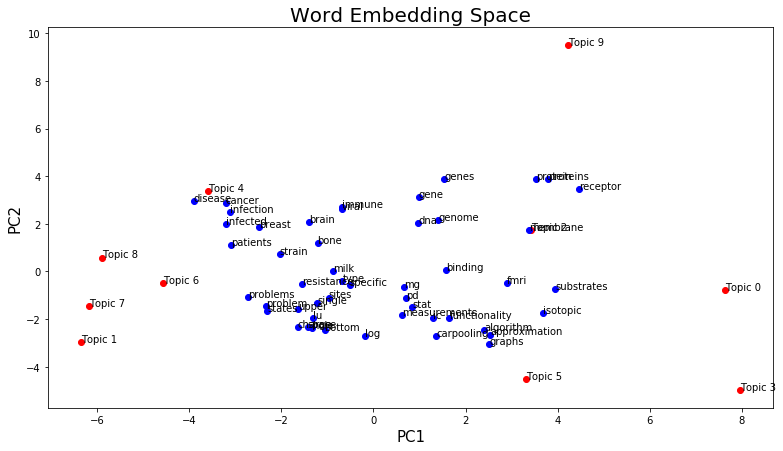

In [111]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,7))
plt.scatter(pca_topics[:,0], pca_topics[:,1],linewidths=1,color='red')
for i, _ in enumerate(topics):
    plt.annotate("Topic "+str(i),xy=(pca_topics[i,0],pca_topics[i,1]))
plt.xlabel("PC1",size=15)
plt.ylabel("PC2",size=15)
plt.title("Word Embedding Space",size=20)
plt.scatter(pca_words[:,0], pca_words[:,1],linewidths=1,color='blue')
for i, word in enumerate(words):
    plt.annotate(word,xy=(pca_words[i,0],pca_words[i,1]))

## 3. Documents embeddings